# PART III
## Kernel perceptron

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from helpers import *
from collections import Counter

np.random.seed(1234)  # give a fixed seed for reproducability
from sklearn.model_selection import train_test_split

In [2]:
#loading data
zipcombo = np.loadtxt('zipcombo.dat')
zipcombo_qater = zipcombo[:len(zipcombo)//3]
training_data = np.loadtxt('dtrain123.dat')
test_data = np.loadtxt('dtest123.dat')

#some training data is continuous, need to make sure everything is either -1 or 1

(257,)


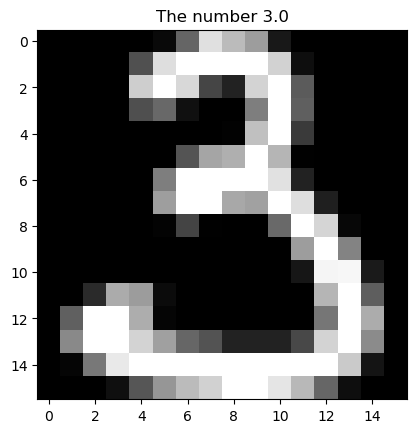

In [3]:
#plot first char
def plot_char(char):
    data = char[1:].reshape(16, 16)
    plt.imshow(data, cmap='gray')
    plt.title(f"The number {char[0]}")
    plt.show()
print(training_data[0].shape)
    
plot_char(training_data[0])

In [4]:
##helper functions(can be extracted into a separate class later)

#polynomial kernel

def polynomial_kernel(p, q, d):
    return (1 + (p@q.T)) ** d

def polynomial_kernel_3D(p, q, d):
    #returns a 3D array of the polynomial kernel of the data, last dimension is the degree
    kernels = np.empty((len(d), len(q), len(p)))
    for i, degree in enumerate(d):
        kernels[i, :, :] = (1 + np.dot(p, q.T)) ** degree

    return kernels

def gaussian_kernel_matrix(X1, X2, sigma):
    # It looks a little weird cause its vectorised
    sq_dists = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
    return np.exp(-sigma * sq_dists)

#convering the data to -1 and 1
def mysign(data):
    return np.where(data <= 0.0, -1.0, 1.0)

#splitting data and labels
def split_into_data_and_labels(data):
    y = data[:,0].astype(int)
    #convert to -1 and 1 here instead of in the loop
    x = data[:, 1:]
    return x, y

In [5]:
def train_kernel_perceptron_online(X, y, K, n_classes, return_training_error=True):
    NB_EPOCHS_MAX = 30
    num_samples = X.shape[0]
    alpha = np.zeros((n_classes, num_samples))
    prev_error = float('inf') 
    epoches = 0
    for epoch in range(NB_EPOCHS_MAX):
        total_mistakes = 0
        for i in range(num_samples):
            scores = np.zeros(n_classes)
            
            scores = K[i]@alpha.T
            predicted_class = np.argmax(scores)
            true_class = y[i]

            if predicted_class != true_class:
                alpha[true_class, i] += 1
                alpha[predicted_class, i] -=1
                total_mistakes += 1  # Increment the total number of mistakes
                
        epoches+=1     
        print(f"Epoch {epoch+1}, number of samples {num_samples}, mistakes this epoch {total_mistakes}")
              
        train_error = total_mistakes / num_samples  # Calculate the training error
        
        # convergence
        if (prev_error - train_error) < 1e-2:
            break
        prev_error = train_error
    if(return_training_error):
        return alpha, train_error
    
    return alpha

In [6]:
def predict_kernel_perceptron(y, alpha, K, return_labels=False):
    # Calculate the scores for all test samples and classes at once
    scores = np.dot(alpha, K.T)

    # Predict the class with the highest score for each test sample
    y_pred = np.argmax(scores, axis=0)

    test_error = np.mean(y != y_pred)
    if(return_labels):
        return test_error, y_pred
    return test_error

## Q1

In [7]:
N_RUNS = 20
d_range = np.arange(1, 8, dtype=int)  # k = 1...7
#substitute for the real data with 10
x_data, y_labels = split_into_data_and_labels(zipcombo_qater)
#can be extraced from data
n_classes = len(np.unique(y_labels))

def run_experiment(x_data, y_labels, N_RUNS, d, n_classes):
    train_errors = np.zeros((N_RUNS, len(d_range)))
    train_errors2 = np.zeros((N_RUNS, len(d_range)))
    test_errors = np.zeros((N_RUNS, len(d_range)))

    for i_run in range(N_RUNS):
        X_train, X_test, y_train, y_test = train_test_split(
            x_data, y_labels, test_size=0.2, random_state=i_run
        )
        n_training_samples = X_train.shape[0]

        for j_ind, j in enumerate(d_range):
            K_train = polynomial_kernel(X_train, X_train, j)
            
            alpha, train_errors[i_run, j_ind] = train_kernel_perceptron_online(X_train, y_train, K_train, n_classes)
            train_errors2[i_run, j_ind] = predict_kernel_perceptron(y_train, alpha, K_train)

            print(f"Run {i_run}, degree {j}, train error {train_errors[i_run, j_ind]}, number of samples {n_training_samples}")
            
            # calculating prediction of the test data
            K_test = polynomial_kernel(X_test, X_train, j)
            test_errors[i_run, j_ind] = predict_kernel_perceptron(y_test, alpha, K_test)
            print(f"Run {i_run}, degree {j}, test error {test_errors[i_run, j_ind]}, number of samples {len(X_test)}")

    mean_train_errors = np.mean(train_errors, axis=0)
    mean_test_errors = np.mean(test_errors, axis=0)
    mean_std_train_errors = np.std(train_errors, axis=0)
    mean_std_test_errors = np.std(test_errors, axis=0)
    
    return mean_train_errors, mean_test_errors, mean_std_train_errors, mean_std_test_errors

mean_train_errors, mean_test_errors, mean_std_train_errors, mean_std_test_errors = run_experiment(x_data, y_labels, N_RUNS, d_range, n_classes)

Run 0, degree 1, train error 0.09955627269060105, number of samples 2479
Run 0, degree 1, test error 0.11451612903225807, number of samples 620
Run 0, degree 2, train error 0.04889068172650262, number of samples 2479
Run 0, degree 2, test error 0.0532258064516129, number of samples 620
Run 0, degree 3, train error 0.036950383219039935, number of samples 2479
Run 0, degree 3, test error 0.054838709677419356, number of samples 620
Run 0, degree 4, train error 0.031383622428398546, number of samples 2479
Run 0, degree 4, test error 0.03387096774193549, number of samples 620
Run 0, degree 5, train error 0.02928600242033078, number of samples 2479
Run 0, degree 5, test error 0.04516129032258064, number of samples 620
Run 0, degree 6, train error 0.028156514723678902, number of samples 2479
Run 0, degree 6, test error 0.043548387096774194, number of samples 620
Run 0, degree 7, train error 0.026381605486083096, number of samples 2479
Run 0, degree 7, test error 0.04516129032258064, number of

In [8]:
# Create a summary table
columns = ['degree', 'mean training error', 'mean train std', 'mean test error', 'mean test std']

# Take an average over all the runs
kernel_perceptron = pd.concat((
    pd.DataFrame(mean_train_errors, columns=[columns[1]]),
    pd.DataFrame(mean_std_train_errors,columns=[columns[2]]),
    pd.DataFrame(mean_test_errors, columns=[columns[3]]),
    pd.DataFrame(mean_std_test_errors, columns=[columns[4]])), axis=1
)
kernel_perceptron.set_index('Polynomial degree ' + pd.Series(d_range).astype(str), inplace=True)
kernel_perceptron.index.name = 'degree'
kernel_perceptron = kernel_perceptron.style.format("{:.5f}")

kernel_perceptron


,mean training error,mean train std,mean test error,mean test std
degree,,,,
Polynomial degree 1,0.09869,0.00515,0.10242,0.01404
Polynomial degree 2,0.04780,0.00139,0.05516,0.00974
Polynomial degree 3,0.03639,0.00162,0.04508,0.00788
Polynomial degree 4,0.03090,0.00095,0.04347,0.00501
Polynomial degree 5,0.03003,0.00243,0.04452,0.00664
Polynomial degree 6,0.02878,0.00291,0.04282,0.00920
Polynomial degree 7,0.02807,0.00264,0.04282,0.00794


## Q2

In [9]:
N_FOLDS = 5
fold_test_prediction_error = np.zeros(shape=(N_RUNS, N_FOLDS, len(d_range)))
test_errors = np.zeros(shape=(N_RUNS))
d_stars = []

for i_run in range(N_RUNS):
    # Use i_run as random state so each run is different but the test_train_split matches the runs
    X_train, X_test, Y_train, Y_test = train_test_split(
        x_data, y_labels, test_size= 0.2, random_state=i_run
    )

    folds_data: list[FoldData] = create_folds_data(X_train, Y_train, number_of_folds=N_FOLDS)

    # Loop to pick the best d_star based on the lowest cross validation error
    for i_fold, fold in enumerate(folds_data):
        fold: FoldData
        for i_j, j in enumerate(d_range):
            K_train_fold = polynomial_kernel(fold.train_data, fold.train_data, j)
            K_test_fold = polynomial_kernel(fold.test_data, fold.train_data, j)
            alpha = train_kernel_perceptron_online(fold.train_data, fold.train_labels, K_train_fold, n_classes, return_training_error = False)

            fold_test_prediction_error[i_run, i_fold, i_j] = predict_kernel_perceptron(fold.test_labels, alpha, K_test_fold)

    # Pick the d star based on the lowest test error
    d_star, _ = get_d_star_from_cross_validation_error(fold_test_prediction_error[i_run, :, :], ds=d_range)
    d_stars.append(d_star)

    # Create a new classifier based on d star and retrained on the whole training set
    K_train = polynomial_kernel(X_train, X_train, d=d_star)
    alpha_star = train_kernel_perceptron_online(X_train, Y_train, K_train, n_classes, return_training_error=False)

    # Get the error of the new training and testing over the whole dataset for this new predictor
    K_test = polynomial_kernel(X_test, X_train, d=d_star)
    test_errors[i_run] = predict_kernel_perceptron(Y_test, alpha_star, K_test)

In [10]:
d_stars
test_errors
print(d_stars)
print(test_errors)
mean_cross_validation_test_error = np.mean(test_errors, axis=0)
mean_cross_validation_test_error_std = np.std(test_errors, axis=0)
mean_cross_validation_d = np.mean(d_stars)
mean_cross_validation_s_std = np.std(d_stars)
print("Mean Test Error: ", mean_cross_validation_test_error, "±", mean_cross_validation_test_error_std)
print("Mean Best d: ", mean_cross_validation_d, "±", mean_cross_validation_s_std)

part_2_results = {
        "Mean Best d": mean_cross_validation_d,
        "Std Best d": mean_cross_validation_s_std,
        "Mean Test Error": mean_cross_validation_test_error,
        "Std Test Error": mean_cross_validation_test_error_std
    }

df_mean_error_rates = pd.DataFrame(mean_cross_validation_d, index=np.arange(10), columns=np.arange(10))
df_std_error_rates = pd.DataFrame(mean_cross_validation_s_std, index=np.arange(10), columns=np.arange(10))

df_restuls_2 = pd.DataFrame.from_dict(part_2_results, orient='index')
df_restuls_2.reset_index(inplace=True)
df_restuls_2

[4, 6, 4, 4, 6, 5, 5, 3, 6, 4, 5, 5, 6, 3, 6, 6, 5, 4, 6, 7]
[0.03387097 0.04193548 0.03548387 0.03870968 0.04032258 0.04354839
 0.04354839 0.04516129 0.05       0.04677419 0.0516129  0.05483871
 0.04677419 0.04193548 0.05806452 0.03387097 0.04193548 0.03870968
 0.0516129  0.05      ]
Mean Test Error:  0.044435483870967754 ± 0.006620275198545337
Mean Best d:  5.0 ± 1.0954451150103321


,index,0
0,Mean Best d,5.000000
1,Std Best d,1.095445
2,Mean Test Error,0.044435
3,Std Test Error,0.006620


## Q3

In [11]:
def confusion_matrix(y_true, y_pred):
    classes = np.unique(y_true)
    matrix = np.zeros((len(classes), len(classes)))

    for true_class in classes:
        for pred_class in classes:
            if true_class != pred_class:  # Exclude diagonal elements
                matrix[true_class, pred_class] = np.sum((y_true == true_class) & (y_pred == pred_class)) / np.sum(y_true == true_class)

    return matrix

def calculate_std_dev(confusion_matrices):
    return np.std(confusion_matrices, axis=0)

In [12]:
fold_test_prediction_error = np.zeros(shape=(N_RUNS, N_FOLDS, len(d_range)))
test_errors = np.zeros(shape=(N_RUNS))
test_errors = np.zeros(shape=(N_RUNS))
confusion_matrices = np.zeros(shape=(N_RUNS, n_classes, n_classes))


for i_run in range(N_RUNS):
    # Use i_run as random state so each run is different but the test_train_split matches the runs
    X_train, X_test, Y_train, Y_test = train_test_split(
        x_data, y_labels, test_size= 0.2, random_state=i_run
    )

    folds_data: list[FoldData] = create_folds_data(X_train, Y_train, number_of_folds=N_FOLDS)

    # Loop to pick the best d_star based on the lowest cross validation error
    for i_fold, fold in enumerate(folds_data):
        fold: FoldData
        for i_j, j in enumerate(d_range):
            K_train_fold = polynomial_kernel(fold.train_data, fold.train_data, j)
            K_test_fold = polynomial_kernel(fold.test_data, fold.train_data, j)
            alpha = train_kernel_perceptron_online(fold.train_data, fold.train_labels, K_train_fold, n_classes, return_training_error = False)

            fold_test_prediction_error[i_run, i_fold, i_j] = predict_kernel_perceptron(fold.test_labels, alpha, K_test_fold)

    # Pick the d star based on the lowest test error
    d_star, _ = get_d_star_from_cross_validation_error(fold_test_prediction_error[i_run, :, :], ds=d_range)

    # Create a new classifier based on d star and retrained on the whole training set
    K_train = polynomial_kernel(X_train, X_train, d=d_star)
    alpha_star = train_kernel_perceptron_online(X_train, Y_train, K_train, n_classes, return_training_error=False)

    # Get the error of the new training and testing over the whole dataset for this new predictor
    K_test = polynomial_kernel(X_test, X_train, d=d_star)
    test_errors[i_run], y_pred = predict_kernel_perceptron(Y_test, alpha_star, K_test, return_labels=True)
    confusion_matrices[i_run, :, :] = confusion_matrix(Y_test, y_pred)

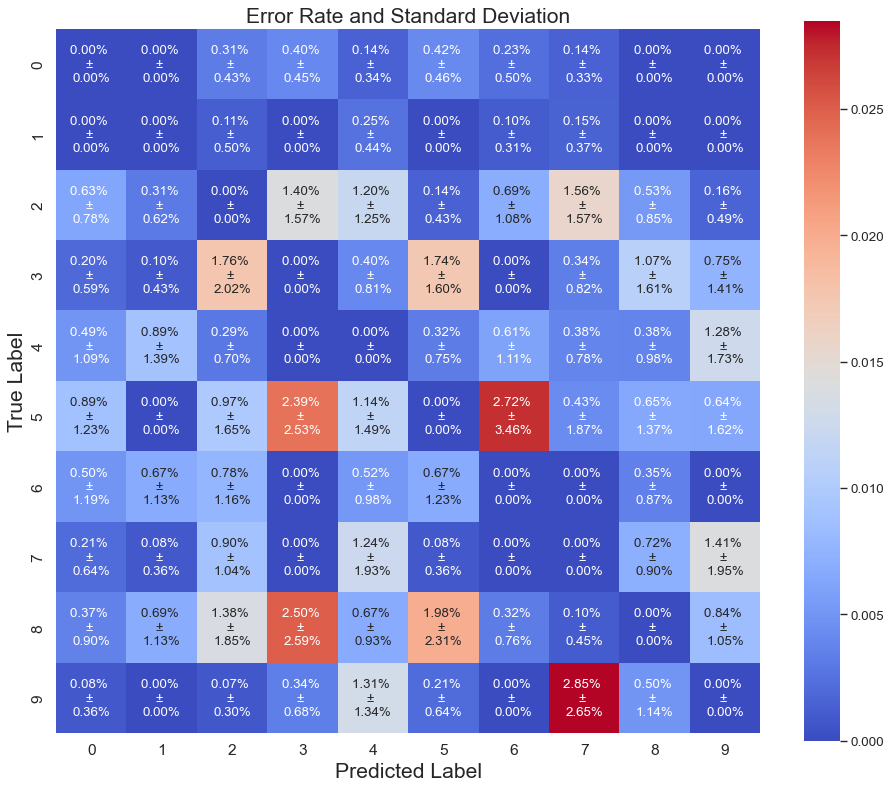

In [13]:
std_dev_matrix = calculate_std_dev(confusion_matrices)
mean_confusion_matrix = confusion_matrices.mean(axis=0)
combined_matrix = np.vectorize(lambda mean, std: f"{mean*100:.2f}% \n± \n{std*100:.2f}%")(mean_confusion_matrix, std_dev_matrix)

plt.figure(figsize=(12, 10), dpi=80)
sns.set(style="whitegrid", font_scale=1.1)
ax = sns.heatmap(mean_confusion_matrix, annot=combined_matrix, fmt="", cmap='coolwarm', cbar=True, square=True, annot_kws={"size": 12}, xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title("Confusion matrix")
plt.title("Error Rate and Standard Deviation", fontsize=19)
plt.xlabel('Predicted Label', fontsize=19)
plt.ylabel('True Label', fontsize=19)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

## Q4

In [14]:
N_RUNS = 20
fold_test_prediction_error = np.zeros(shape=(N_RUNS, N_FOLDS, len(d_range)))
test_errors = np.zeros(shape=(N_RUNS))
test_errors = np.zeros(shape=(N_RUNS))
misclassified_images = {}

for i_run in range(N_RUNS):
    # Use i_run as random state so each run is different but the test_train_split matches the runs
    X_train, X_test, Y_train, Y_test = train_test_split(
        x_data, y_labels, test_size= 0.2, random_state=i_run
    )

    folds_data: list[FoldData] = create_folds_data(X_train, Y_train, number_of_folds=N_FOLDS)

    # Loop to pick the best d_star based on the lowest cross validation error
    for i_fold, fold in enumerate(folds_data):
        fold: FoldData
        for i_j, j in enumerate(d_range):
            K_train_fold = polynomial_kernel(fold.train_data, fold.train_data, j)
            K_test_fold = polynomial_kernel(fold.test_data, fold.train_data, j)
            alpha = train_kernel_perceptron_online(fold.train_data, fold.train_labels, K_train_fold, n_classes, return_training_error = False)

            fold_test_prediction_error[i_run, i_fold, i_j] = predict_kernel_perceptron(fold.test_labels, alpha, K_test_fold)

    # Pick the d star based on the lowest test error
    d_star, _ = get_d_star_from_cross_validation_error(fold_test_prediction_error[i_run, :, :], ds=d_range)

    # Create a new classifier based on d star and retrained on the whole training set
    K_train = polynomial_kernel(X_train, X_train, d=d_star)
    alpha_star = train_kernel_perceptron_online(X_train, Y_train, K_train, n_classes, return_training_error=False)

    # Get the error of the new training and testing over the whole dataset for this new predictor
    K_test = polynomial_kernel(X_test, X_train, d=d_star)
    test_errors[i_run], y_pred = predict_kernel_perceptron(Y_test, alpha_star, K_test, return_labels=True)
    misclassified_indices = np.where(y_pred!=Y_test)[0]
    misclassified_images[i_run] = {}
    for index in misclassified_indices:
        true_label = Y_test[index]
        misclassified_images[i_run][true_label] = X_test[index]
    

In [15]:
print(misclassified_indices)
print(misclassified_images)

[ 40  43  62 108 112 153 165 166 172 241 256 260 264 292 314 326 327 330
 335 380 389 415 430 447 507 510 539 551 589 610 614]
{0: {8: array([-1.   , -1.   , -1.   , -1.   , -1.   , -0.981,  0.005,  0.744,
        1.   ,  0.892, -0.102, -0.619, -1.   , -1.   , -1.   , -1.   ,
       -1.   , -1.   , -1.   , -0.993, -0.264,  0.773,  1.   ,  1.   ,
        1.   ,  1.   ,  1.   ,  0.995, -0.137, -1.   , -1.   , -1.   ,
       -1.   , -1.   , -1.   ,  0.225,  0.998,  1.   ,  0.935,  0.071,
       -0.868, -0.258,  1.   ,  1.   ,  0.287, -1.   , -1.   , -1.   ,
       -1.   , -1.   , -1.   ,  0.279,  1.   ,  0.181, -0.703, -1.   ,
       -0.808,  0.808,  1.   ,  1.   , -0.219, -1.   , -1.   , -1.   ,
       -1.   , -1.   , -1.   ,  0.156, -0.008, -0.979, -1.   , -0.857,
        0.605,  1.   ,  1.   ,  0.64 , -0.93 , -1.   , -1.   , -1.   ,
       -1.   , -1.   , -1.   ,  0.034, -0.639, -1.   , -0.904,  0.399,
        1.   ,  1.   ,  1.   , -0.586, -1.   , -1.   , -1.   , -1.   ,
       -1.   

{8: 19, 7: 18, 5: 19, 4: 18, 2: 20, 0: 19, 9: 19, 6: 16, 1: 10, 3: 19}
5


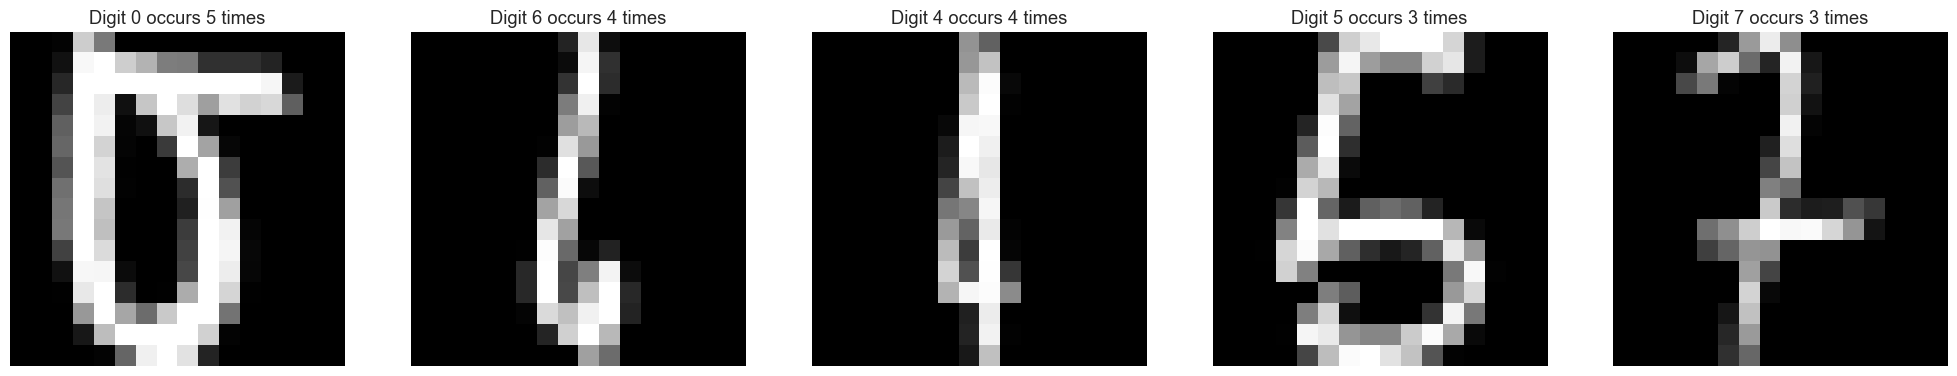

In [16]:
from collections import Counter
label_counts = {}
image_counts = Counter()
image_data = []


for i_run in misclassified_images:
    for label in misclassified_images[i_run]:
        if label not in label_counts:
            label_counts[label] = 0
        label_counts[label] +=1
        image = tuple(misclassified_images[i_run][label].flatten())
        if image not in image_counts:
            image_counts[image] = 1
            image_data.append({'image': image, 'count': image_counts[image], 'label': label})
        else:
            image_counts[image] += 1
            # Find the corresponding dictionary in image_data and update its count
            for image_dict in image_data:
                if image_dict['image'] == image:
                    image_dict['count'] = image_counts[image]
                    break
  
print(label_counts)

total_counts = {}

# Iterate over the images in image_data
for image_dict in image_data:
    image, count, label = image_dict['image'], image_dict['count'], image_dict['label']

    # If the image is already in total_counts, add the count to the existing count
    # Otherwise, set the count and label as the total count and label for this image
    if image in total_counts:
        total_counts[image]['count'] += count
    else:
        total_counts[image] = {'count': count, 'label': label}

# Convert total_counts back to a list of dictionaries
image_data = [{'image': image, 'count': data['count'], 'label': data['label']} for image, data in total_counts.items()]

#print image that is most misclassified
#most_common_images = image_data.image_counts.most_common(5)
image_data.sort(key=lambda x: x['count'], reverse=True)

# Get the 5 most common images
most_common_images = image_data[:5]
print(len(most_common_images))
# Create a figure with multiple subplots
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

# Display each of the 5 most common images in its own subplot
for ax, data in zip(axes, most_common_images):
    image, count, label = data['image'], data['count'], data['label']

    image = np.array(image).reshape(16, 16)
    # Display the image
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    # Display the count as the title of the subplot
    ax.set_title(f"Digit {label} occurs {count} times")

plt.show()

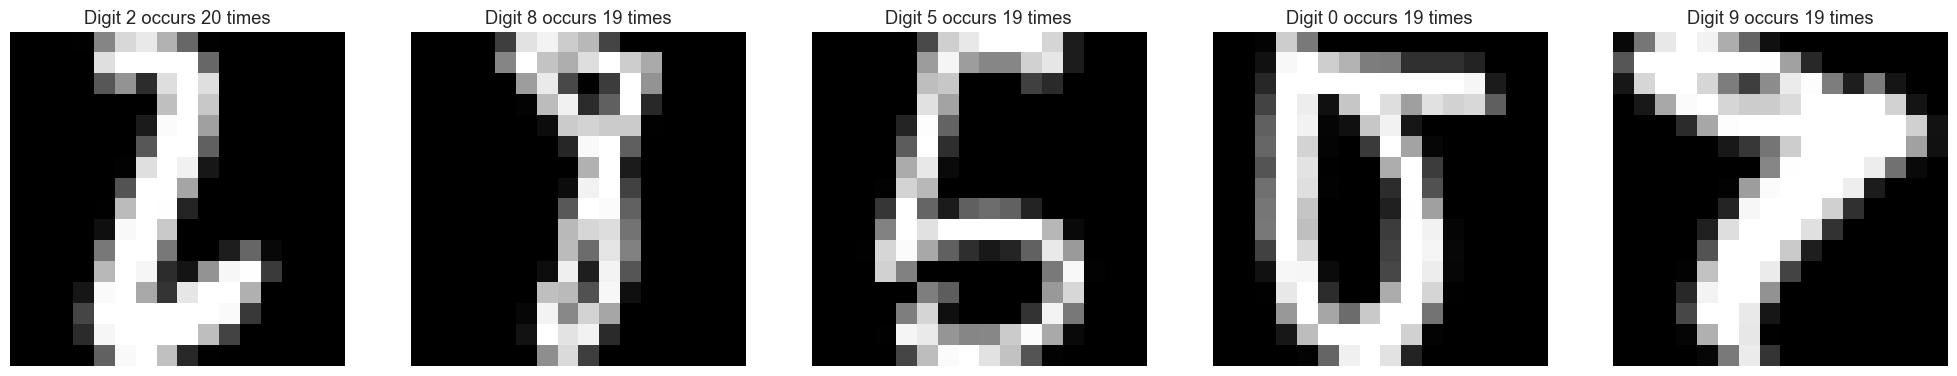

In [17]:
def get_first_image_by_label(label):
    for image_dict in image_data:
        if image_dict['label'] == label:
            return image_dict['image']

fig, axes = plt.subplots(1, 5, figsize=(25, 5))
most_common_labels = Counter(label_counts).most_common(5)

for ax, label_data in zip(axes, most_common_labels):
    label, count = label_data[0], label_data[1]
    image1 = np.array(get_first_image_by_label(label)).reshape(16, 16)
    ax.imshow(image1, cmap='gray')
    ax.axis('off')
    # Display the count as the title of the subplot
    ax.set_title(f"Digit {label} occurs {count} times")

plt.show()

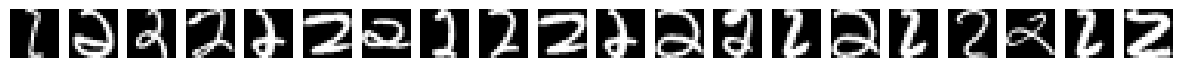

In [18]:
most_misclassified_label = max(label_counts, key=label_counts.get)
label_counter = Counter(label_counts)
most_common_labels = label_counter.most_common(5)
most_misclassified_images = []
for i_run in misclassified_images:
    if most_misclassified_label in misclassified_images[i_run]:
        most_misclassified_images.append(misclassified_images[i_run][most_misclassified_label])

fig, axes = plt.subplots(1, len(most_misclassified_images), figsize=(15, 5))

for ax, image in zip(axes, most_misclassified_images):
    
    data = image.reshape(16, 16)
    ax.imshow(data, cmap='gray')
    ax.axis('off')

plt.show()

Counter({2: 20, 8: 19, 5: 19, 0: 19, 9: 19, 3: 19, 7: 18, 4: 18, 6: 16, 1: 10})
5


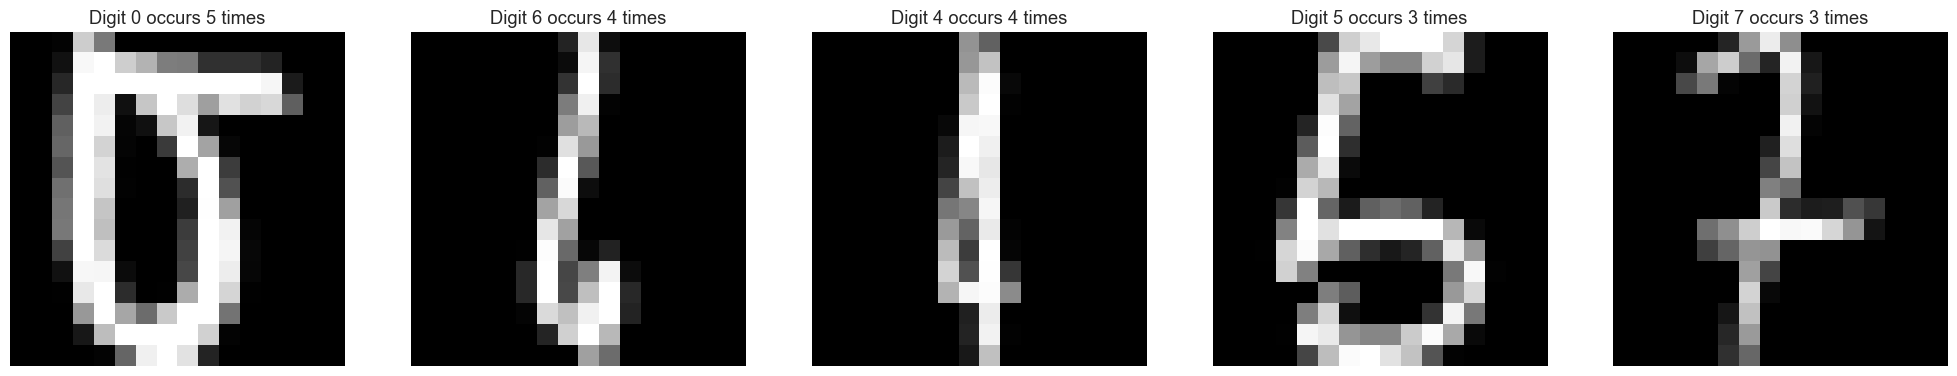

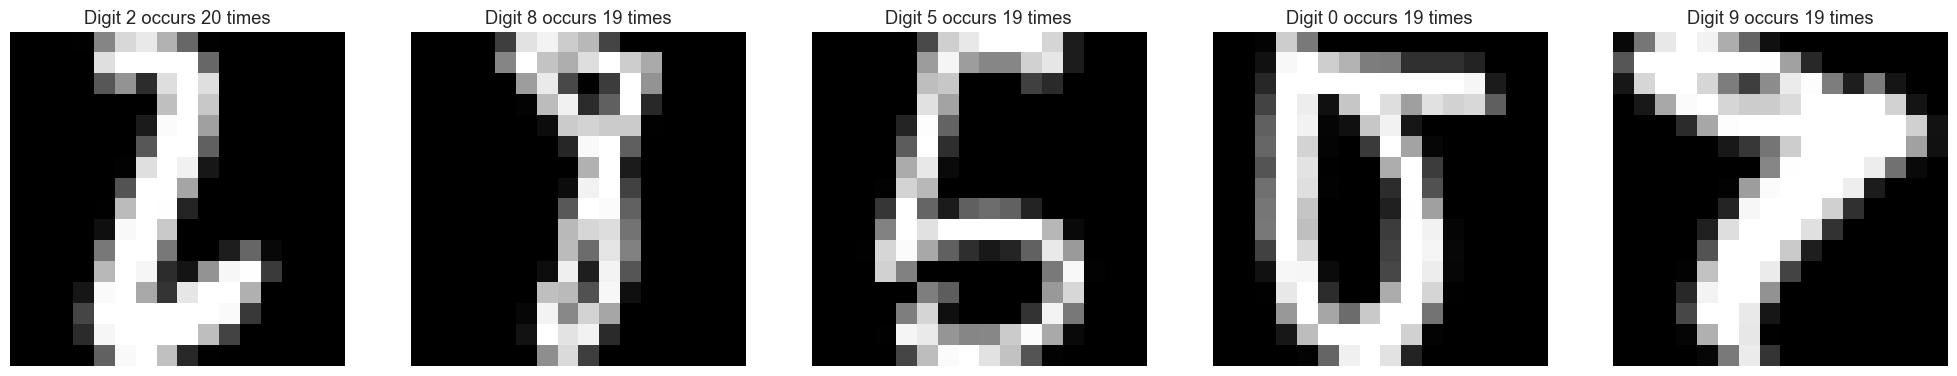

In [19]:
from collections import Counter
from matplotlib import pyplot as plt
import numpy as np

# Initialize counters and data list
label_counts = Counter()
image_counts = Counter()
image_data = []

# Count labels and images
for i_run, labels in misclassified_images.items():
    for label, image in labels.items():
        image = tuple(image.flatten())
        label_counts[label] += 1
        image_counts[image] += 1

        # Add new image data or update count of existing image data
        for image_dict in image_data:
            if image_dict['image'] == image:
                image_dict['count'] = image_counts[image]
                break
        else:
            image_data.append({'image': image, 'count': image_counts[image], 'label': label})

print(label_counts)

# Sort image data by count in descending order
image_data.sort(key=lambda x: x['count'], reverse=True)

# Get the 5 most common images
most_common_images = image_data[:5]
print(len(most_common_images))

# Create a figure with multiple subplots
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

# Display each of the 5 most common images in its own subplot
for ax, data in zip(axes, most_common_images):
    image, count, label = data['image'], data['count'], data['label']
    image = np.array(image).reshape(16, 16)
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    ax.set_title(f"Digit {label} occurs {count} times")

plt.show()

def get_first_image_by_label(label):
    for image_dict in image_data:
        if image_dict['label'] == label:
            return image_dict['image']

fig, axes = plt.subplots(1, 5, figsize=(25, 5))
most_common_labels = label_counts.most_common(5)

for ax, (label, count) in zip(axes, most_common_labels):
    image1 = np.array(get_first_image_by_label(label)).reshape(16, 16)
    ax.imshow(image1, cmap='gray')
    ax.axis('off')
    ax.set_title(f"Digit {label} occurs {count} times")

plt.show()

## Q5

In [20]:
N_RUNS = 20
c_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
#substitute for the real data with 10
x_data, y_labels = split_into_data_and_labels(zipcombo_qater)
#can be extraced from data
n_classes = len(np.unique(y_labels))

def run_experiment(x_data, y_labels, N_RUNS, c_range, n_classes):
    train_errors_gauss = np.zeros((N_RUNS, len(c_range)))
    train_errors2_gauss = np.zeros((N_RUNS, len(c_range)))
    test_errors_gauss = np.zeros((N_RUNS, len(c_range)))

    for i_run in range(N_RUNS):
        X_train, X_test, y_train, y_test = train_test_split(
            x_data, y_labels, test_size=0.2, random_state=i_run
        )
        n_training_samples = X_train.shape[0]

        for j_ind, j in enumerate(c_range):
            K_train = gaussian_kernel_matrix(X_train, X_train, j)
            
            alpha, train_errors_gauss[i_run, j_ind] = train_kernel_perceptron_online(X_train, y_train, K_train, n_classes)
            train_errors2_gauss[i_run, j_ind] = predict_kernel_perceptron(y_train, alpha, K_train)

            # calculating prediction of the test data
            K_test = gaussian_kernel_matrix(X_test, X_train, j)
            test_errors_gauss[i_run, j_ind] = predict_kernel_perceptron(y_test, alpha, K_test)

    mean_train_errors_gauss = np.mean(train_errors_gauss, axis=0)
    mean_test_errors_gauss = np.mean(test_errors_gauss, axis=0)
    mean_std_train_errors_gauss = np.std(train_errors_gauss, axis=0)
    mean_std_test_errors_gauss = np.std(test_errors_gauss, axis=0)
    
    return mean_train_errors_gauss, mean_test_errors_gauss, mean_std_train_errors_gauss, mean_std_test_errors_gauss

mean_train_errors_gauss, mean_test_errors_gauss, mean_std_train_errors_gauss, mean_std_test_errors_gauss = run_experiment(x_data, y_labels, N_RUNS, c_range, n_classes)

In [21]:
mean_train_errors_gauss

array([0.11409699, 0.03284893, 0.02799516, 0.03010085, 0.04821645,
       0.07804491, 0.08199677])

In [22]:
# Create a summary table
columns = ['sigma', 'mean training error', 'mean train std', 'mean test error', 'mean test std']

# Take an average over all the runs
kernel_perceptron = pd.concat((
    pd.DataFrame(mean_train_errors_gauss, columns=[columns[1]]),
    pd.DataFrame(mean_std_train_errors_gauss,columns=[columns[2]]),
    pd.DataFrame(mean_test_errors_gauss, columns=[columns[3]]),
    pd.DataFrame(mean_std_test_errors_gauss, columns=[columns[4]])), axis=1
)
kernel_perceptron.set_index((pd.Series(c_range, name='c')), inplace=True)
kernel_perceptron.index.name = 'sigma'
kernel_perceptron = kernel_perceptron.style.format("{:.5f}")

kernel_perceptron

,mean training error,mean train std,mean test error,mean test std
sigma,,,,
0.001000,0.11410,0.00479,0.09266,0.02328
0.010000,0.03285,0.00171,0.04266,0.00974
0.100000,0.02800,0.00105,0.06331,0.00735
1.000000,0.03010,0.00105,0.07210,0.00952
10.000000,0.04822,0.00051,0.24742,0.01097
100.000000,0.07804,0.00289,0.70492,0.01376
1000.000000,0.08200,0.00028,0.81984,0.01120


In [23]:
N_FOLDS = 5
fold_test_prediction_error = np.zeros(shape=(N_RUNS, N_FOLDS, len(c_range)))
test_errors = np.zeros(shape=(N_RUNS))
c_stars = []

for i_run in range(N_RUNS):
    # Use i_run as random state so each run is different but the test_train_split matches the runs
    X_train, X_test, Y_train, Y_test = train_test_split(
        x_data, y_labels, test_size= 0.2, random_state=i_run
    )

    folds_data: list[FoldData] = create_folds_data(X_train, Y_train, number_of_folds=N_FOLDS)

    # Loop to pick the best d_star based on the lowest cross validation error
    for i_fold, fold in enumerate(folds_data):
        fold: FoldData
        for i_j, j in enumerate(c_range):
            K_train_fold = gaussian_kernel_matrix(fold.train_data, fold.train_data, j)
            K_test_fold = gaussian_kernel_matrix(fold.test_data, fold.train_data, j)
            alpha = train_kernel_perceptron_online(fold.train_data, fold.train_labels, K_train_fold, n_classes, return_training_error = False)

            fold_test_prediction_error[i_run, i_fold, i_j] = predict_kernel_perceptron(fold.test_labels, alpha, K_test_fold)

    # Pick the d star based on the lowest test error
    c_star, _ = get_d_star_from_cross_validation_error(fold_test_prediction_error[i_run, :, :], ds=c_range)
    print(c_star)
    c_stars.append(c_star)

    # Create a new classifier based on d star and retrained on the whole training set
    K_train = gaussian_kernel_matrix(X_train, X_train, c_star)
    alpha_star = train_kernel_perceptron_online(X_train, Y_train, K_train, n_classes, return_training_error=False)

    # Get the error of the new training and testing over the whole dataset for this new predictor
    K_test = gaussian_kernel_matrix(X_test, X_train, c_star)
    test_errors[i_run] = predict_kernel_perceptron(Y_test, alpha_star, K_test)

In [24]:
c_stars
test_errors
print(c_stars)
print(test_errors)
mean_cross_validation_test_error = np.mean(test_errors, axis=0)
mean_cross_validation_test_error_std = np.std(test_errors, axis=0)
mean_cross_validation_c = np.mean(c_stars)
mean_cross_validation_s_std = np.std(c_stars)
print("Mean Test Error: ", mean_cross_validation_test_error, "±", mean_cross_validation_test_error_std)
print("Mean Best c: ", mean_cross_validation_c, "±", mean_cross_validation_s_std)

part_2_results = {
        "Mean Best c": mean_cross_validation_c,
        "Std Best c": mean_cross_validation_s_std,
        "Mean Test Error": mean_cross_validation_test_error,
        "Std Test Error": mean_cross_validation_test_error_std
    }

df_restuls_2 = pd.DataFrame.from_dict(part_2_results, orient='index')
df_restuls_2.reset_index(inplace=True)
pd.set_option('display.float_format', '{:.20f}'.format)
df_restuls_2

[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
[0.03870968 0.0483871  0.01935484 0.03387097 0.04354839 0.04354839
 0.06612903 0.0483871  0.05483871 0.03870968 0.03709677 0.04032258
 0.05483871 0.03709677 0.0483871  0.02903226 0.04032258 0.04032258
 0.0483871  0.04193548]
Mean Test Error:  0.04266129032258064 ± 0.009737381439303121
Mean Best c:  0.010000000000000002 ± 1.734723475976807e-18


,index,0
0,Mean Best c,0.01000000000000000194
1,Std Best c,0.00000000000000000173
2,Mean Test Error,0.04266129032258064030
3,Std Test Error,0.00973738143930312147


In [26]:
## BAD CODE DEMO

# Function to compute the polynomial kernel of degree 3
def compute_kernel(a, b):
    return (np.dot(a, b))**3

# Function to compute the sign of a number
def compute_sign(x):
    return -1.0 if x <= 0.0 else 1.0

# Function to initialize the classifier weights
def initialize_weights(data):
    return np.zeros((3, len(data)))

# Function to compute the prediction for a given pattern
def compute_prediction(data, pattern, classifier):
    return sum(classifier[i] * compute_kernel(pattern, data[i][1:]) for i in range(len(classifier)))

# Function to train the classifiers
def train_classifiers(data):
    global classifier_weights
    classifier_weights = initialize_weights(data)
    num_mistakes = 0

    for i in range(len(data)):
        true_class = data[i][0]

        # Compute the predictions of the 3 classifiers
        predictions = [compute_prediction(data, data[i][1:], classifier_weights[j]) for j in range(3)]
        
        max_prediction = float("-inf")
        for j in range(3):
            expected_output = 1.0 if true_class == (j + 1) else -1.0
            
            # Update the classifier weights if the prediction is incorrect
            if expected_output * predictions[j] <= 0:
                classifier_weights[j, i] -= compute_sign(predictions[j])
            if predictions[j] > max_prediction:
                max_prediction = predictions[j]
                predicted_class = j + 1
                
        # Increment the mistake counter if the predicted class is not the true class
        if predicted_class != true_class:
            num_mistakes += 1

    return num_mistakes

# Train the model and get the number of mistakes
mistakes = train_classifiers(training_data)
print("Number of mistakes:", mistakes)

# Access the global variable GLBcls after training
print("GLBcls shape:", classifier_weights.shape)

Number of mistakes: 15
GLBcls shape: (3, 329)
